In [39]:
# ==============================================================================
# CELLULE 1 : IMPORTS ET CONFIGURATION
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
import os

# Modèles et Métriques
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Ajout du chemin vers tes scripts locaux (src)
sys.path.append('..')
from src.sampling import get_sample_weights

# Configuration de l'affichage
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings('ignore')

print("✅ Environnement prêt.")

✅ Environnement prêt.


In [40]:
# ==============================================================================
# CELLULE 2 : CHARGEMENT ET PRÉPARATION DES DONNÉES
# ==============================================================================
print("1. Chargement des données...")

# On charge les features stationnaires (FFD) et les labels (Triple Barrier)
# Assure-toi que ces fichiers ont été générés par les notebooks 02 et 03
try:
    X = pd.read_parquet('../data/processed/train_stationary.parquet')
    y_data = pd.read_parquet('../data/processed/labels.parquet')
except FileNotFoundError:
    print("❌ ERREUR : Fichiers introuvables. Lance les notebooks 02 et 03 d'abord.")
    raise

# Alignement des index (Intersection stricte)
# On ne garde que les dates où on a À LA FOIS des features et un label calculé
common_idx = X.index.intersection(y_data.index)
X = X.loc[common_idx]
y = y_data.loc[common_idx, 'bin']
events_meta = y_data.loc[common_idx] # Contient t1, ret, etc. pour les poids

print(f"Dataset initial aligné : {X.shape} observations.")

1. Chargement des données...
Dataset initial aligné : (1917, 100) observations.


In [41]:
# ------------------------------------------------------------------------------
# ÉTAPE CRITIQUE : CALCUL DU PROXY PRIX AVANT NETTOYAGE
# ------------------------------------------------------------------------------
# On a besoin des rendements bruts pour calculer la magnitude des mouvements (Poids)
# On calcule le prix synthétique MAINTENANT, avant de supprimer la colonne 'forward_returns'.
if 'forward_returns' in X.columns:
    price_proxy = (1 + X['forward_returns']).cumprod()
else:
    raise ValueError("La colonne 'forward_returns' est manquante ! Impossible de calculer les poids.")

In [42]:
# ------------------------------------------------------------------------------
# ÉTAPE CRITIQUE : ANTI-LEAKAGE (Suppression du futur)
# ------------------------------------------------------------------------------
# On supprime tout ce qui contient la réponse
cols_to_drop = [
    'forward_returns', 
    'market_forward_excess_returns', 
    'lagged_forward_returns', 
    'lagged_market_forward_excess_returns',
    'risk_free_rate',
    'date_id' # Si présent en colonne
]
# On ne supprime que ce qui existe réellement
cols_to_drop = [c for c in cols_to_drop if c in X.columns]
X = X.drop(columns=cols_to_drop)

print(f"Features restantes après nettoyage (X) : {X.shape[1]}")
print("✅ Leakage supprimé. Prêt pour le calcul des poids.")

Features restantes après nettoyage (X) : 97
✅ Leakage supprimé. Prêt pour le calcul des poids.


In [43]:
# ==============================================================================
# CELLULE 3 : CALCUL DES POIDS (SAMPLE WEIGHTS)
# ==============================================================================
print("\n2. Calcul des Sample Weights (Chapitre 4 - Gestion de la redondance)...")

# Récupération de la date de fin de trade (t1) depuis les métadonnées
t1 = events_meta['t1']

# Appel à notre fonction src/sampling.py
# Cela calcule l'unicité (chevauchement) et le rendement absolu
w_raw = get_sample_weights(t1, price_proxy, events_meta, X.index)

# Nettoyage des poids (NaNs au début remplacés par la moyenne)
w_raw = w_raw.fillna(w_raw.mean())

# CORRECTION CRITIQUE XGBOOST : NORMALISATION
# On ramène la moyenne à 1.0 pour que XGBoost ne considère pas les données comme négligeables
# (sinon min_child_weight bloque l'apprentissage)
w_train = w_raw / w_raw.mean()

print(f"Stats des poids normalisés : Min={w_train.min():.4f}, Max={w_train.max():.4f}, Mean={w_train.mean():.4f}")


2. Calcul des Sample Weights (Chapitre 4 - Gestion de la redondance)...
Stats des poids normalisés : Min=0.0000, Max=11.1678, Mean=1.0000



3. Sélection des Features (Nettoyage du bruit)...
✅ Top 20 features conservées : ['M11', 'I4', 'P8', 'P10_ffd_vol', 'D6', 'E12', 'P10_ffd', 'E9', 'S11', 'S10', 'E16', 'P1', 'E6', 'S1', 'S5', 'S9', 'M16', 'V13', 'S4', 'M9']


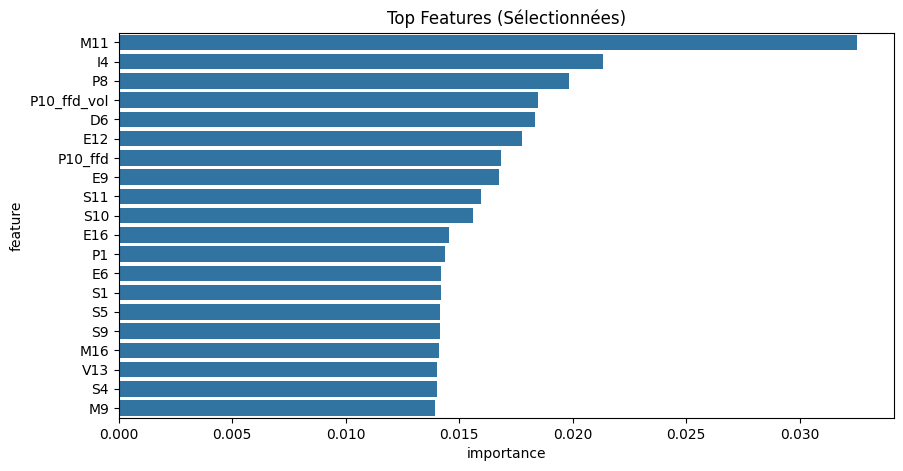

In [44]:
# ==============================================================================
# CELLULE 4 : SÉLECTION DE FEATURES (MDI)
# ==============================================================================
print("\n3. Sélection des Features (Nettoyage du bruit)...")

# On utilise un modèle temporaire rapide pour juger les features
rf_selector = XGBClassifier(n_estimators=100, max_depth=4, n_jobs=-1, random_state=42)
rf_selector.fit(X, y, sample_weight=w_train.values)

# Extraction de l'importance
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

# --- ACTION : ON GARDE UNIQUEMENT LE TOP 20 ---
# C'est ici qu'on élimine le bruit qui confondait le modèle
TOP_N = 20
top_features = importances.head(TOP_N)['feature'].tolist()

print(f"✅ Top {TOP_N} features conservées : {top_features}")

# Visualisation rapide
plt.figure(figsize=(10, 5))
sns.barplot(x='importance', y='feature', data=importances.head(TOP_N))
plt.title("Top Features (Sélectionnées)")
plt.show()

# On filtre le dataset X pour ne garder que le top
X_lean = X[top_features]

In [45]:
# ==============================================================================
# CELLULE 5 : VALIDATION CROISÉE PURGÉE (PURGED K-FOLD)
# ==============================================================================
print(f"\n4. Validation Croisée Purgée (Vérification de la robustesse)...")

# Configuration du modèle final (Hyperparamètres validés précédemment)
def get_model_config():
    # Calcul du ratio pour scale_pos_weight (équilibrage des classes)
    sum_w_neg = w_train[y == 0].sum()
    sum_w_pos = w_train[y == 1].sum()
    scale_ratio = sum_w_neg / sum_w_pos
    
    return XGBClassifier(
        n_estimators=1000,      
        max_depth=4,            # Profondeur moyenne
        learning_rate=0.01,     # Apprentissage lent
        subsample=0.7,          # Bagging
        colsample_bytree=0.7,   # Feature Bagging
        gamma=0.5,              # Régularisation forte (Anti-Bruit)
        reg_alpha=0.5,          # L1 (Sélection)
        scale_pos_weight=scale_ratio,
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=50 # Arrêt si pas de progrès sur le set de validation
    )

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=False) # IMPORTANT: Pas de shuffle temporel
t1_series = events_meta['t1']

scores = []
fold = 1

for train_idx, test_idx in cv.split(X_lean):
    # 1. PURGE (Supprimer les fuites entre Train et Test)
    test_start_time = X_lean.index[test_idx[0]]
    train_idx_purged = [i for i in train_idx if t1_series.iloc[i] < test_start_time]
    
    # Création des sets pour ce fold
    X_tr = X_lean.iloc[train_idx_purged]
    y_tr = y.iloc[train_idx_purged]
    w_tr = w_train.iloc[train_idx_purged]
    
    X_te = X_lean.iloc[test_idx]
    y_te = y.iloc[test_idx]
    
    # Entraînement
    model = get_model_config()
    model.fit(
        X_tr, y_tr, 
        sample_weight=w_tr.values,
        eval_set=[(X_te, y_te)],
        verbose=False
    )
    
    # Score
    preds = model.predict_proba(X_te)[:, 1]
    score = roc_auc_score(y_te, preds)
    print(f"Fold {fold}/{n_splits} - ROC-AUC: {score:.4f}")
    scores.append(score)
    fold += 1

print(f"\n📊 Score Moyen CV: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
# Si > 0.52, c'est très bon.


4. Validation Croisée Purgée (Vérification de la robustesse)...
Fold 1/5 - ROC-AUC: 0.5000
Fold 2/5 - ROC-AUC: 0.5270
Fold 3/5 - ROC-AUC: 0.5310
Fold 4/5 - ROC-AUC: 0.5342
Fold 5/5 - ROC-AUC: 0.5094

📊 Score Moyen CV: 0.5203 (+/- 0.0133)


In [46]:
# ==============================================================================
# CELLULE 6 : ENTRAÎNEMENT FINAL ET SAUVEGARDE
# ==============================================================================
print("\n5. Entraînement Final sur 100% des données...")

# On réinstancie le modèle (sans early_stopping car pas de validation set ici)
# On limite le nombre d'arbres à une valeur moyenne observée pendant la CV (ex: 800-1200)
final_model = get_model_config()
final_model.set_params(n_estimators=1200, early_stopping_rounds=None)

# Fit sur tout le dataset
final_model.fit(
    X_lean, 
    y, 
    sample_weight=w_train.values
)

print("✅ Modèle entraîné sur tout l'historique.")


5. Entraînement Final sur 100% des données...
✅ Modèle entraîné sur tout l'historique.


In [47]:
# --- SAUVEGARDE POUR LA SOUMISSION ---
if not os.path.exists('../submission'):
    os.makedirs('../submission')

print("\nSauvegarde des fichiers...")
joblib.dump(final_model, '../submission/model_lpd.pkl')
joblib.dump(top_features, '../submission/features_list.pkl') # Très important
# joblib.dump(X_lean.mean(), '../submission/means.pkl') # Optionnel

print(f"💾 Fichiers prêts dans submission/ :")
print(f"   - model_lpd.pkl")
print(f"   - features_list.pkl (Contient : {len(top_features)} features)")

print("\n👉 PROCHAINE ÉTAPE : Uploader ces fichiers dans ton Dataset Kaggle !")


Sauvegarde des fichiers...
💾 Fichiers prêts dans submission/ :
   - model_lpd.pkl
   - features_list.pkl (Contient : 20 features)

👉 PROCHAINE ÉTAPE : Uploader ces fichiers dans ton Dataset Kaggle !
